# STAT207 Final Project - Predictive Analysis of Alcohol Consumption of Portuguese Students


Zhisheng Hua

In [1]:
#Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Introduction

This analysis aims to develop a predictive model for student weekend alcohol consumption ("Walc") based on attributes of secondary school students. Specifically, the primary research goal is to build a binary classification model to effectively predict whether students report low (1-2) or high (3-5) weekend drinking levels.

School counselors and administrators could utilize such a model to identify students more likely to engage in problematic drinking. Middle schools and high schools have the ability to implement highly effective programs to reduce youth alcohol consumption.<sup>1</sup> The priority would be detecting high-risk students, rather than focusing on overall accuracy equally. Underage and binge drinking brings greater health and safety concerns according to the CDC<sup>2</sup>, so minimizing false negatives is key for intervention.

At least five explanatory variables will be considered, encompassing: demographics like age and gender; family factors including quality of relationships ("famrel"); academic engagement through absences and extracurricular activities; and existing weekday drinking levels ("Dalc"). Both numerical and categorical inputs will be included.

Predictive performance on new datasets is the primary research goal. The secondary goals are developing reliable interpretability into variable relationships, as well as thorough descriptive analytics of the data.

## 2. Dataset Discussion

The dataset used in this analysis is the Student Alcohol Consumption dataset, which contains math and Portuguese grades and social attributes for students at two Portuguese secondary schools. The dataset was downloaded from the Kaggle on November 24, 2023 and originally contains 1044 rows representing individual students. The dataset can be found [here](https://www.kaggle.com/datasets/uciml/student-alcohol-consumption).

The data was collected via surveys conducted at the two schools in 2008 (Cortez & Silva, 2008). As it only encompasses students from these schools, the observations are not necessarily inclusive of all student types in Portugal. Students from other regions or ethnic groups may be missing, potentially limiting what school administrators could infer from model results.

The response variable selected is "Walc" - weekend alcohol consumption level. This five-level categorical variable indicates the frequency of a student's weekend drinking, from very low (1) to very high (5). It will be converted to a binary indicator of low (1-2) vs high (3-5) weekend drinking for the classification task.

Seven explanatory variables were chosen covering demographics, academics, home life, and health. We also considered alcohol consumption during the week (Monday - Friday). 

numerical vars:   
age - student's age in years  
absences - number of times student was absent from school  
studytime - hours of time spend studying during the week rated on a scale from 1 to 4  
famrel - student's relationship with family rated on a scale from 1 to 5  
health - student's current health status on a scale from 1 to 5  
Dalc - student's level of alcohol consumption during the week on a scale from 1 to 5  

categorical vars:  
sex - male or female  

These inputs provide diverse perspectives into personal and school factors believed to be associated with underage and binge drinking based on prior research studies. We will use the column names to refer to the explanatory variables from this point onward. 

In [2]:
df_por = pd.read_csv('student-por.csv')
df_mat = pd.read_csv('student-mat.csv') 
df = pd.concat([df_por, df_mat], axis=0)
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [3]:
df.shape[0]

1044

## 3. Dataset Cleaning

Firstly, we filtered our dataset to contain only the columns of interest.

The student alcohol dataset does not contain any explicit missing values upon inspection. All 1044 rows have complete observations with no blank or null entries. Therefore no rows need to be dropped due to missing inputs. Avoiding case deletion preserves more information for analysis, though estimation techniques could have been used if needed.

The dataset does not contain any implicit missing values either. Each numerical column has data of type int and sex has only "M" and "F" strings.

The categorical explanatory variables like sex only have two levels, so no sample size issues exist that would warrant dropping any minority groups.

Scatterplots revealed some outliers between pairs of our chosen numerical explanatory variables - age, absences, studytime weekly, famrel, health, and Dalc (weekday drinking). Specifically, absences had a couple of high outliers. We decided to drop students who had over 40 absences, which deleted 3 rows from our data. This means that our predictions will be less skewed towards extreme values; however, our predictions for weekend alcohol consumption will not be as accurate for students with over 40 absences. 

An additional step taken was converting the originally numeric Walc variable into a binary indicator of low (1-2) vs high (3-5) weekend drinking. This simplified the classification task to distinguish students of highest concern and supports more straightforward interpretability. No rows were dropped during this process.

In [4]:
df = df[['sex','age','absences','famrel','studytime','Dalc','health', 'Walc']]  

In [5]:
# Handle missing values
print(df.isnull().sum())

sex          0
age          0
absences     0
famrel       0
studytime    0
Dalc         0
health       0
Walc         0
dtype: int64


In [6]:
df.dtypes

sex          object
age           int64
absences      int64
famrel        int64
studytime     int64
Dalc          int64
health        int64
Walc          int64
dtype: object

In [7]:
print(df['sex'].value_counts()) 

F    591
M    453
Name: sex, dtype: int64


In [8]:
df_1 = df.reset_index()

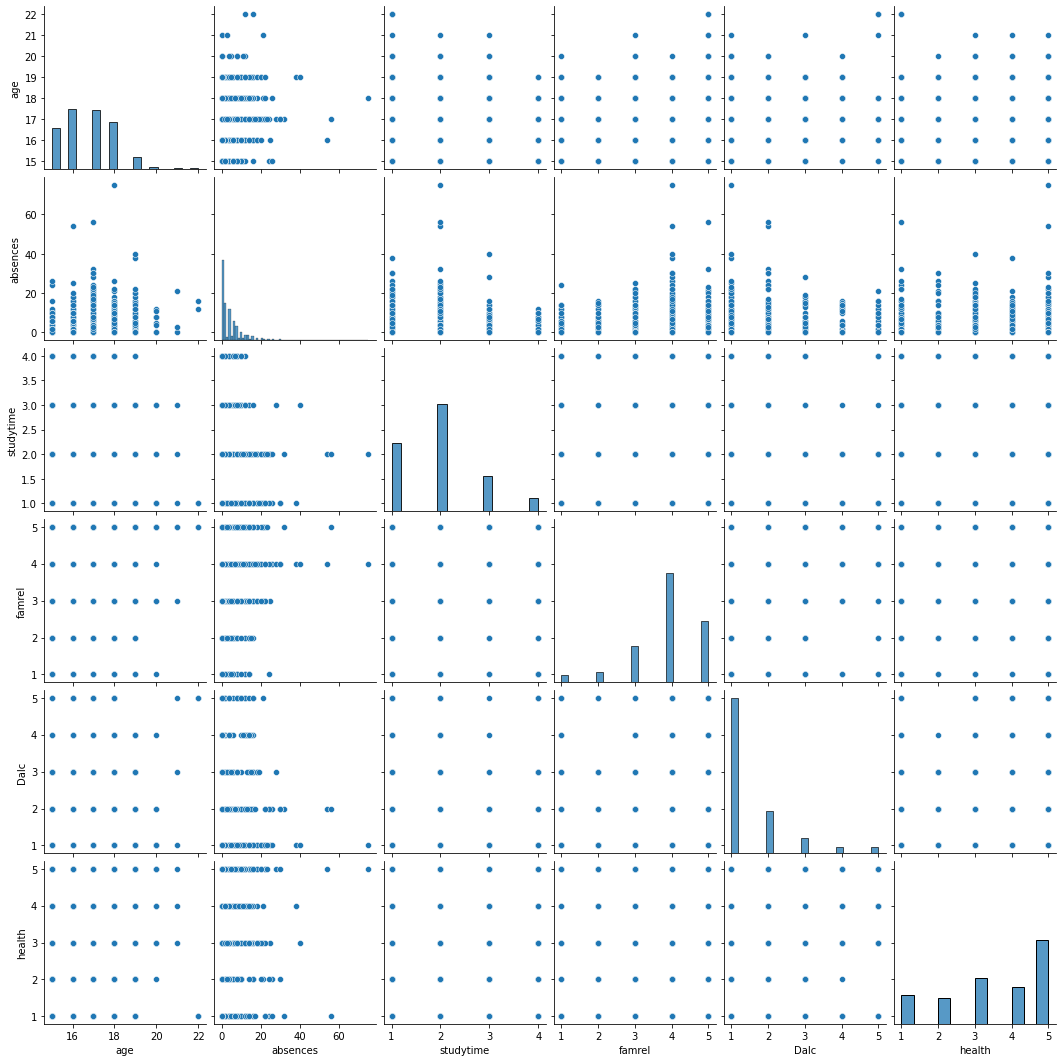

In [9]:
sns.pairplot(df_1[['age', 'absences', 'studytime', 'famrel', 'Dalc', 'health']])
plt.show()

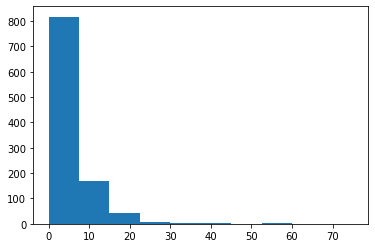

In [10]:
plt.hist(x='absences', data=df_1)
plt.show()

In [11]:
df = df[df.absences <= 40]

In [12]:
df.shape[0]

1041

In [13]:
def classify_drinking(n):
    if n <= 2:
        return 'Low'
    else: 
        return 'High'

df['Walc_class'] = df['Walc'].apply(classify_drinking) 

print(df['Walc_class'].value_counts()) 

Low     632
High    409
Name: Walc_class, dtype: int64


## 4. Preliminary Analysis

Age and weekend alcohol consumption do not have an association with each other as there is a complete overlap between the two boxplots that represent low and high consumption. In comparison, absences, studytime, famrel, and Dalc all have a significant difference between the two boxplots, showing that they have an effect on the response variable.

Sex is a categorical variable, so the relationship can be visualized as a barplot of the relative frequency of the observations in each category (low consumption and high consumption). It can be deduced that sex does affect alchol distribution, as there is a similar frequency of men in each category, but there is a higher frequency of women who consume a low amount of alcohol on the weekend.

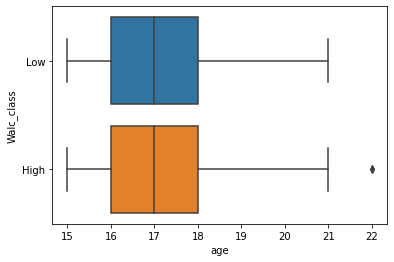

In [14]:
sns.boxplot(x='age', y='Walc_class', data=df)
plt.show()

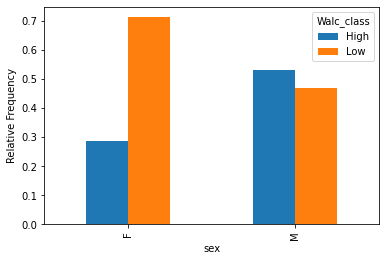

In [15]:
temp = pd.crosstab(df['sex'], df['Walc_class'], normalize='index')
temp.plot.bar()
plt.ylabel('Relative Frequency')
plt.show()

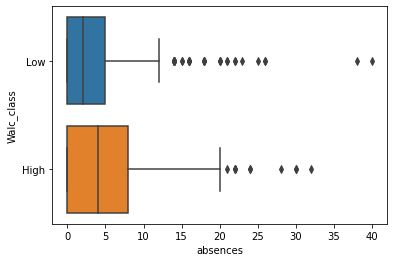

In [16]:
sns.boxplot(x='absences', y='Walc_class', data=df)
plt.show()

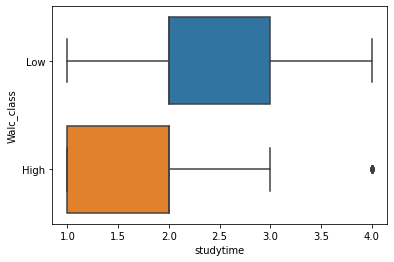

In [17]:
sns.boxplot(x='studytime', y='Walc_class', data=df)
plt.show()

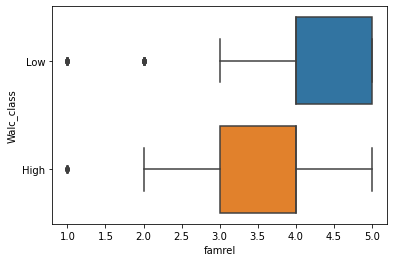

In [18]:
sns.boxplot(x='famrel', y='Walc_class', data=df)
plt.show()

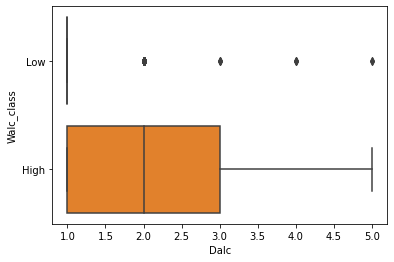

In [19]:
sns.boxplot(x='Dalc', y='Walc_class', data=df)
plt.show()

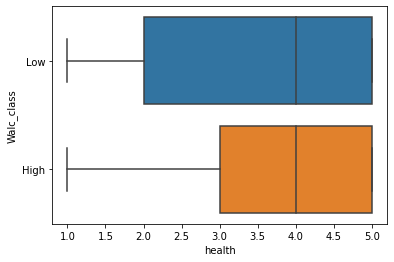

In [20]:
sns.boxplot(x='health', y='Walc_class', data=df)
plt.show()

Age, absences, studytime, famrel, Dalc, and health are all numerical explanatory variables, so the relationship can be visualized in a scatterplot. There are no significant correlations between any of the numerical variables as the r < 0.7 for all pairwise relationships. 

The relationship between sex and the numerical explanatory variables can be visualized in using boxplots. There is almost complete overlap between the boxplots for the two sexes for age and absences, suggesting that there is no relationship between these variables. There does seem to be a strong relationship between sex and studytime as well as famrel as women reported that they studied more than men and had worse relationships with their family on average. We can also see a relationship between Dalc and sex, as almsot all women report not drinking during the week, while the top 25 % of men rate themselves at either a 2 or 3. Finally, women seem to rate themselves slightly worse than men for health, which suggests a relationship between sex and healh.

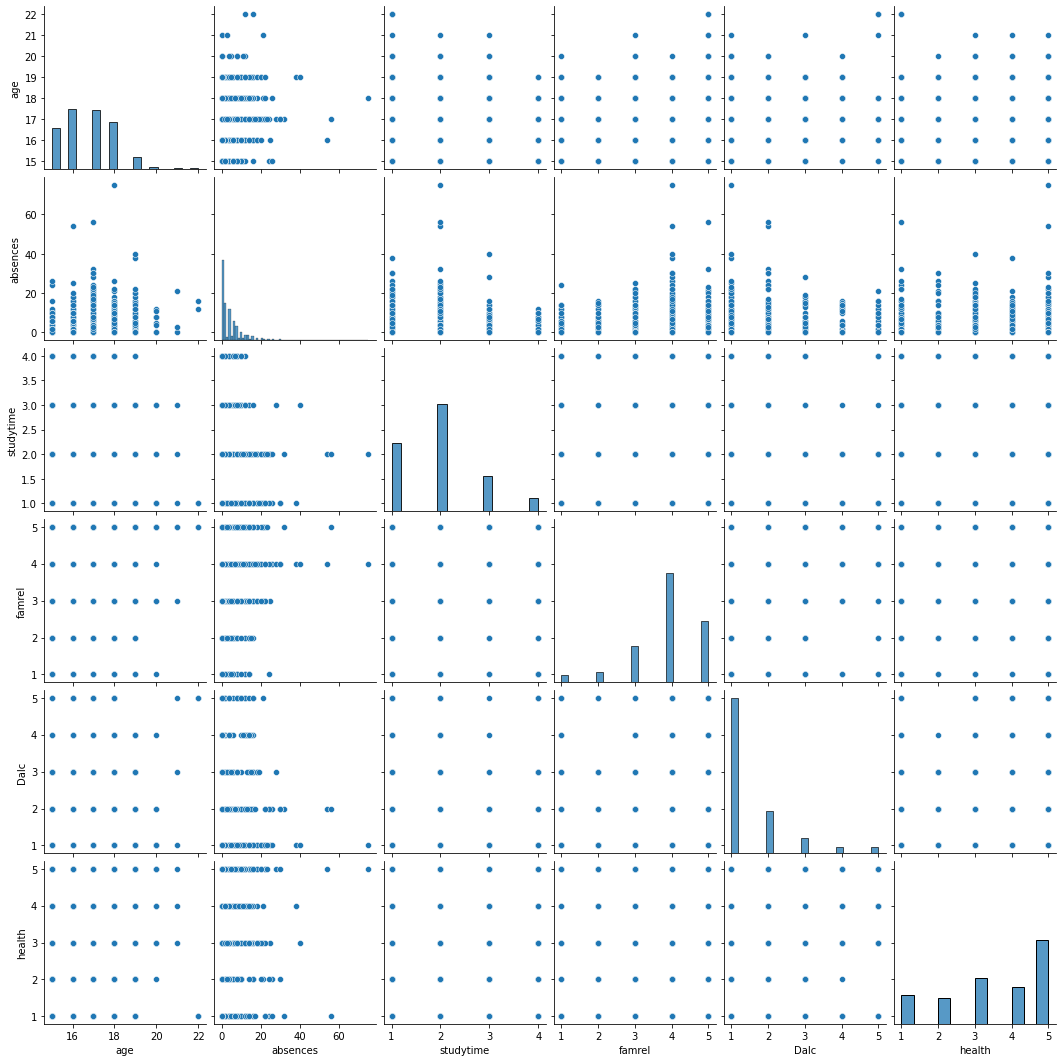

In [21]:
sns.pairplot(df_1[['age', 'absences', 'studytime', 'famrel', 'Dalc', 'health']])
plt.show()

In [22]:
df[['age', 'absences', 'studytime', 'famrel', 'Dalc', 'health']].corr()

,age,absences,studytime,famrel,Dalc,health
age,1.000000,0.167398,-0.007898,0.006900,0.134332,-0.029279
absences,0.167398,1.000000,-0.088480,-0.083926,0.150458,-0.037365
studytime,-0.007898,-0.088480,1.000000,0.012288,-0.159754,-0.063214
famrel,0.006900,-0.083926,0.012288,1.000000,-0.077173,0.106253
Dalc,0.134332,0.150458,-0.159754,-0.077173,1.000000,0.066650
health,-0.029279,-0.037365,-0.063214,0.106253,0.066650,1.000000


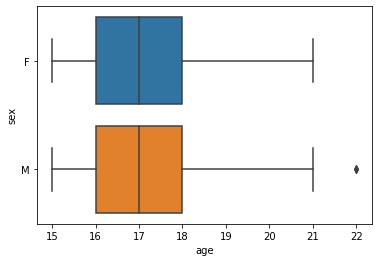

In [23]:
sns.boxplot(x='age', y='sex', data=df)
plt.show()

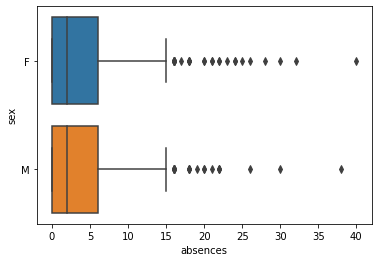

In [24]:
sns.boxplot(x='absences', y='sex', data=df)
plt.show()

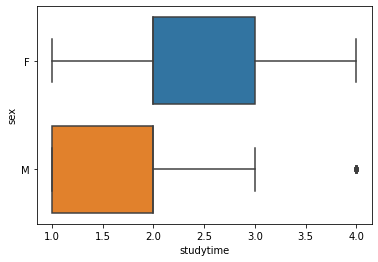

In [25]:
sns.boxplot(x='studytime', y='sex', data=df)
plt.show()

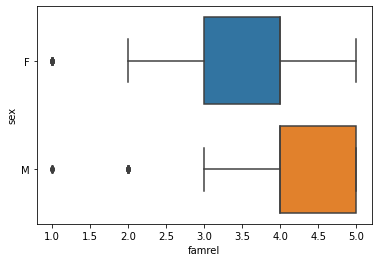

In [26]:
sns.boxplot(x='famrel', y='sex', data=df)
plt.show()

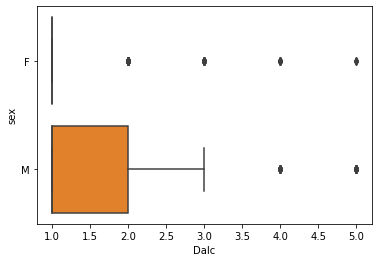

In [27]:
sns.boxplot(x='Dalc', y='sex', data=df)
plt.show()

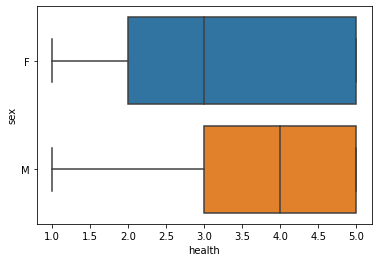

In [28]:
sns.boxplot(x='health', y='sex', data=df)
plt.show()

The only explanatory variable pair that shows an interaction in how it affects the response variable y is age and sex, as there is a noteable difference in shape of the sigmoid curves created from the logistic regression models. The coefficient values for age in the models differ based on the sex of the students. The other models only have slight differences based on sex. 

In [29]:
df['y'] = df['Walc_class'].replace({'High':1, 'Low':0})

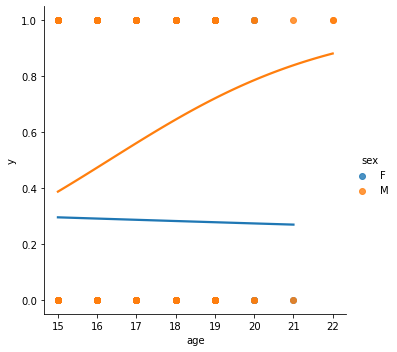

In [30]:
sns.lmplot(x='age', y='y', hue='sex', data=df, logistic=True, ci=False)
plt.show()

In [31]:
simple_log_model = smf.logit("y~age+sex", data=df[df.sex == "M"]).fit()
simple_log_model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.667210
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-5.7414,1.302,-4.410,0.000,-8.293,-3.190
age,0.3522,0.078,4.505,0.000,0.199,0.505


In [32]:
simple_log_model = smf.logit("y~age+sex", data=df[df.sex == "F"]).fit()
simple_log_model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.599755
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.5480,1.294,-0.423,0.672,-3.084,1.988
age,-0.0215,0.077,-0.279,0.780,-0.172,0.130


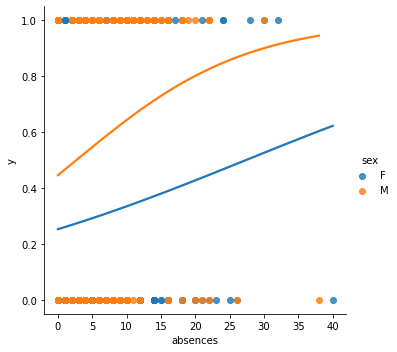

In [33]:
sns.lmplot(x='absences', y='y', hue='sex', data=df, logistic=True, ci=False)
plt.show()

In [34]:
simple_log_model = smf.logit("y~absences+sex", data=df[df.sex == "M"]).fit()
simple_log_model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.672574
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.2165,0.126,-1.717,0.086,-0.464,0.031
absences,0.0806,0.021,3.863,0.000,0.040,0.122


In [35]:
simple_log_model = smf.logit("y~absences+sex", data=df[df.sex == "F"]).fit()
simple_log_model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.594592
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-1.0836,0.117,-9.241,0.000,-1.313,-0.854
absences,0.0396,0.016,2.498,0.013,0.009,0.071


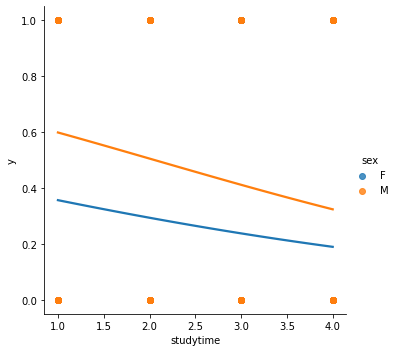

In [36]:
sns.lmplot(x='studytime', y='y', hue='sex', data=df, logistic=True, ci=False)
plt.show()

In [37]:
simple_log_model = smf.logit("y~studytime+sex", data=df[df.sex == "M"]).fit()
simple_log_model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.679791
         Iterations 4


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.7795,0.228,3.421,0.001,0.333,1.226
studytime,-0.3789,0.119,-3.178,0.001,-0.613,-0.145


In [38]:
simple_log_model = smf.logit("y~studytime+sex", data=df[df.sex == "F"]).fit()
simple_log_model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.594580
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.3024,0.260,-1.164,0.244,-0.811,0.207
studytime,-0.2875,0.118,-2.444,0.015,-0.518,-0.057


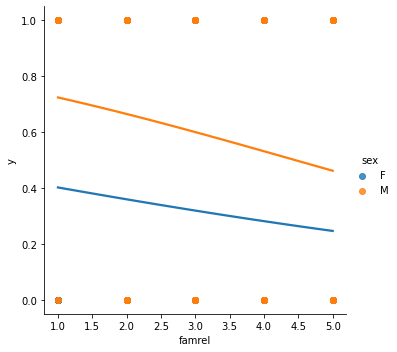

In [39]:
sns.lmplot(x='famrel', y='y', hue='sex', data=df, logistic=True, ci=False)
plt.show()

In [40]:
simple_log_model = smf.logit("y~famrel+sex", data=df[df.sex == "M"]).fit()
simple_log_model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.683843
         Iterations 4


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,1.2448,0.450,2.764,0.006,0.362,2.127
famrel,-0.2795,0.109,-2.566,0.010,-0.493,-0.066


In [41]:
simple_log_model = smf.logit("y~famrel+sex", data=df[df.sex == "F"]).fit()
simple_log_model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.596662
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.2163,0.365,-0.592,0.554,-0.932,0.500
famrel,-0.1802,0.093,-1.939,0.052,-0.362,0.002


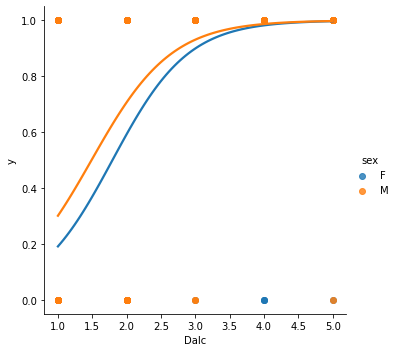

In [42]:
sns.lmplot(x='Dalc', y='y', hue='sex', data=df, logistic=True, ci=False)
plt.show()

In [43]:
simple_log_model = smf.logit("y~Dalc+sex", data=df[df.sex == "M"]).fit()
simple_log_model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.517396
         Iterations 7


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-2.5652,0.286,-8.973,0.000,-3.126,-2.005
Dalc,1.7223,0.192,8.993,0.000,1.347,2.098


In [44]:
simple_log_model = smf.logit("y~Dalc+sex", data=df[df.sex == "F"]).fit()
simple_log_model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.503496
         Iterations 6


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-3.2592,0.285,-11.430,0.000,-3.818,-2.700
Dalc,1.8168,0.211,8.595,0.000,1.402,2.231


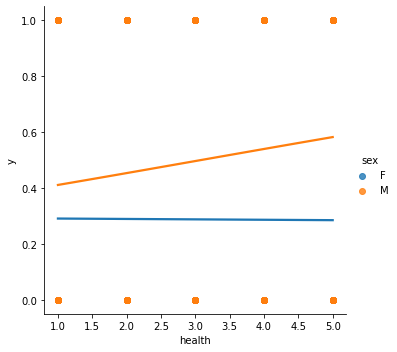

In [45]:
sns.lmplot(x='health', y='y', hue='sex', data=df, logistic=True, ci=False)
plt.show()

In [46]:
simple_log_model = smf.logit("y~health+sex", data=df[df.sex == "M"]).fit()
simple_log_model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.684601
         Iterations 4


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.5325,0.281,-1.894,0.058,-1.084,0.019
health,0.1730,0.070,2.462,0.014,0.035,0.311


In [47]:
simple_log_model = smf.logit("y~health+sex", data=df[df.sex == "F"]).fit()
simple_log_model.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.599810
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.8841,0.230,-3.845,0.000,-1.335,-0.433
health,-0.0071,0.063,-0.113,0.910,-0.130,0.116


## 5. Model Data Preprocessing

In [48]:
X = df.drop(['Walc_class', 'y', 'Walc'], axis=1)
y = df['y']

In [49]:
scaler_training = StandardScaler()
scaled_exp_vars = scaler_training.fit_transform(X[['age', 'absences', 'studytime', 'famrel', 'Dalc', 'health']])
X[['age', 'absences', 'studytime', 'famrel', 'Dalc', 'health']] = scaled_exp_vars

In [50]:
X = pd.get_dummies(X, drop_first = True, dtype = int)
X.head()

,age,absences,famrel,studytime,Dalc,health,sex_M
0,1.027761,-0.050200,0.069959,0.035657,-0.541285,-0.381556,0
1,0.221507,-0.422145,1.140956,0.035657,-0.541285,-0.381556,0
2,-1.391001,0.321745,0.069959,0.035657,0.554975,-0.381556,0
3,-1.391001,-0.794089,-1.001037,1.233043,-0.541285,1.024460,0
4,-0.584747,-0.794089,0.069959,0.035657,-0.541285,1.024460,0


## 6. Feature Selection with k-Fold Cross-Validation

In [51]:
cross_val = KFold(n_splits=5, shuffle=True, random_state=100) 
cross_val

KFold(n_splits=5, random_state=100, shuffle=True)

In [52]:
# Current model:

current_mod = LogisticRegression(penalty = 'none',solver = 'newton-cg', max_iter = 1000)
current_mod.fit(X,y)
scores = cross_val_score(current_mod, X, y, cv=cross_val, scoring='roc_auc')
print("Mean Test Fold AUC:", scores.mean())

Mean Test Fold AUC: 0.812095511183259


In [53]:
# Test models:

X1 = X[['absences','famrel','studytime','sex_M','Dalc','health']]
red_mod = LogisticRegression(penalty = 'none', solver = 'newton-cg', max_iter = 1000)
red_mod.fit(X1,y)
scores = cross_val_score(red_mod, X1, y, cv=cross_val, scoring='roc_auc')
print("Mean Test Fold AUC:", scores.mean())

Mean Test Fold AUC: 0.8101133960928528


In [54]:
X1 = X[['age','famrel','studytime','sex_M','Dalc','health']]
red_mod = LogisticRegression(penalty = 'none', solver = 'newton-cg', max_iter = 1000)
red_mod.fit(X1,y)
scores = cross_val_score(red_mod, X1, y, cv=cross_val, scoring='roc_auc')
print("Mean Test Fold AUC:", scores.mean())

Mean Test Fold AUC: 0.8087714884361809


In [55]:
X1 = X[['age','absences','studytime','sex_M','Dalc','health']]
red_mod = LogisticRegression(penalty = 'none', solver = 'newton-cg', max_iter = 1000)
red_mod.fit(X1,y)
scores = cross_val_score(red_mod, X1, y, cv=cross_val, scoring='roc_auc')
print("Mean Test Fold AUC:", scores.mean())

Mean Test Fold AUC: 0.81205626621024


In [56]:
X1 = X[['age','absences','famrel','sex_M','Dalc','health']]
red_mod = LogisticRegression(penalty = 'none', solver = 'newton-cg', max_iter = 1000)
red_mod.fit(X1,y)
scores = cross_val_score(red_mod, X1, y, cv=cross_val, scoring='roc_auc')
print("Mean Test Fold AUC:", scores.mean())

Mean Test Fold AUC: 0.8083468877464284


In [57]:
X1 = X[['age','absences','famrel','studytime','Dalc','health']]
red_mod = LogisticRegression(penalty = 'none', solver = 'newton-cg', max_iter = 1000)
red_mod.fit(X1,y)
scores = cross_val_score(red_mod, X1, y, cv=cross_val, scoring='roc_auc')
print("Mean Test Fold AUC:", scores.mean())

Mean Test Fold AUC: 0.8040702506745845


In [58]:
X1 = X[['age','absences','famrel','studytime','sex_M','health']]
red_mod = LogisticRegression(penalty = 'none', solver = 'newton-cg', max_iter = 1000)
red_mod.fit(X1,y)
scores = cross_val_score(red_mod, X1, y, cv=cross_val, scoring='roc_auc')
print("Mean Test Fold AUC:", scores.mean())

Mean Test Fold AUC: 0.683797927574143


In [59]:
X1 = X[['age','absences','famrel','studytime','sex_M','Dalc']]
red_mod = LogisticRegression(penalty = 'none', solver = 'newton-cg', max_iter = 1000)
red_mod.fit(X1,y)
scores = cross_val_score(red_mod, X1, y, cv=cross_val, scoring='roc_auc')
print("Mean Test Fold AUC:", scores.mean())

Mean Test Fold AUC: 0.8123646396682442


In [60]:
# Current model:

X1 = X[['age','absences','famrel','studytime','sex_M','Dalc']]
current_mod = LogisticRegression(penalty = 'none', solver = 'newton-cg', max_iter = 1000)
current_mod.fit(X1,y)
scores = cross_val_score(red_mod, X1, y, cv=cross_val, scoring='roc_auc')
print("Mean Test Fold AUC:", scores.mean())

Mean Test Fold AUC: 0.8123646396682442


In [61]:
# Test models: 

X2 = X[['absences','famrel','studytime','sex_M','Dalc']]
red_mod = LogisticRegression(penalty = 'none', solver = 'newton-cg', max_iter = 1000)
red_mod.fit(X2,y)
scores = cross_val_score(current_mod, X2, y, cv=cross_val, scoring='roc_auc')
print("Mean Test Fold AUC:", scores.mean())

Mean Test Fold AUC: 0.8104420019349263


In [62]:
X2 = X[['age','famrel','studytime','sex_M','Dalc']]
red_mod = LogisticRegression(penalty = 'none',solver = 'newton-cg', max_iter = 1000)
red_mod.fit(X2,y)
scores = cross_val_score(red_mod, X2, y, cv=cross_val, scoring='roc_auc')
print("Mean Test Fold AUC:", scores.mean())

Mean Test Fold AUC: 0.8082393617647758


In [63]:
X2 = X[['age','absences','studytime','sex_M','Dalc']]
red_mod = LogisticRegression(penalty = 'none', solver = 'newton-cg', max_iter = 1000)
red_mod.fit(X2,y)
scores = cross_val_score(red_mod, X2, y, cv=cross_val, scoring='roc_auc')
print("Mean Test Fold AUC:", scores.mean())

Mean Test Fold AUC: 0.8119659094004661


In [64]:
X2 = X[['age','absences','famrel','sex_M','Dalc']]
red_mod = LogisticRegression(penalty = 'none', solver = 'newton-cg', max_iter = 1000)
red_mod.fit(X2,y)
scores = cross_val_score(red_mod, X2, y, cv=cross_val, scoring='roc_auc')
print("Mean Test Fold AUC:", scores.mean())

Mean Test Fold AUC: 0.8094543388278839


In [65]:
X2 = X[['age','absences','famrel','studytime','Dalc']]
red_mod = LogisticRegression(penalty = 'none', solver = 'newton-cg', max_iter = 1000)
red_mod.fit(X2,y)
scores = cross_val_score(red_mod, X2, y, cv=cross_val, scoring='roc_auc')
print("Mean Test Fold AUC:", scores.mean())

Mean Test Fold AUC: 0.8030857858410172


The current model is the best model.

## 7. Best Model Discussion

In [66]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 101)

In [67]:
#y column
df_train['y'] = df_train['Walc_class'].replace({'High':1, 'Low':0})
df_test['y'] = df_test['Walc_class'].replace({'High':1, 'Low':0})

#features matrix
X_train = df_train.drop(['y', 'Walc', 'Walc_class'], axis=1)
X_test = df_test.drop(['y', 'Walc', 'Walc_class'], axis=1)

#target array
y_train = df_train['y']
y_test = df_test['y']

#scaling training matrix
scaler_training2 = StandardScaler()
scaled_train_expl_vars = scaler_training2.fit_transform(X_train[['age', 'absences', 'famrel', 'studytime', 'Dalc', 'health']])
X_train[['age', 'absences', 'famrel', 'studytime', 'Dalc', 'health']] = scaled_train_expl_vars

#scaling test matrix
scaled_test_expl_vars = scaler_training2.transform(X_test[['age', 'absences', 'famrel', 'studytime', 'Dalc', 'health']])
X_test[['age', 'absences', 'famrel', 'studytime', 'Dalc', 'health']] = scaled_test_expl_vars

#get dummies 
X_train = pd.get_dummies(X_train, drop_first = True, dtype = int)
X_test = pd.get_dummies(X_test, drop_first = True, dtype = int)

In [68]:
X1_train = X_train[['age','absences','famrel','studytime','sex_M','Dalc']]
current_mod.fit(X1_train,y_train)

LogisticRegression(max_iter=1000, penalty='none', solver='newton-cg')

In [69]:
pd.DataFrame(current_mod.coef_.T,index = X1_train.columns)

,0
age,0.041535
absences,0.219839
famrel,0.003408
studytime,-0.157731
sex_M,0.593116
Dalc,1.514443


In [70]:
current_mod.intercept_.T

array([-0.56214021])

$\hat{y}= -0.56214021 + 0.041535age + 0.219839absences + 0.003408famrel - 0.157731studytime + 0.593116sex_M + 1.514443Dalc$

In [71]:
X1_train.corr()

,age,absences,famrel,studytime,sex_M,Dalc
age,1.000000,0.153162,0.010699,-0.009408,-0.002103,0.131267
absences,0.153162,1.000000,-0.092347,-0.089768,-0.006896,0.125802
famrel,0.010699,-0.092347,1.000000,-0.013784,0.074262,-0.088514
studytime,-0.009408,-0.089768,-0.013784,1.000000,-0.219386,-0.155849
sex_M,-0.002103,-0.006896,0.074262,-0.219386,1.000000,0.249563
Dalc,0.131267,0.125802,-0.088514,-0.155849,0.249563,1.000000


Since there are no correlation coefficients above the 0.7 threshold the model doesn't have an issue with multicollinearity.

The explanatory variables in this model were scaled, so we can also interpret their slopes in terms of importance, in particular:
1. The most important explanatory variable is 𝐷𝑎𝑙𝑐, with a slope of 1.514443
2. The second most important explanatory variable is 𝑠𝑒𝑥𝑀, with a slope of 0.593116
3. The third variable in terms of importance is 𝑎𝑏𝑠𝑒𝑛𝑐𝑒𝑠, with a slope of 0.219839
4. The fourth variable is 𝑠𝑡𝑢𝑑𝑦𝑡𝑖𝑚𝑒, with a slope of −0.157731
5. The fifth variable is 𝑎𝑔𝑒, with a slope of 0.041535
6. The last variable is 𝑓𝑎𝑚𝑟𝑒𝑙, with a slope of 0.003408

The variable "health" is not present in the final model, in order to understand why we can look at the stregth of the relationship between this variable and the other explanatory variables to look for multicollinearity:

In [72]:
X_train.corr()

,age,absences,famrel,studytime,Dalc,health,sex_M
age,1.000000,0.153162,0.010699,-0.009408,0.131267,-0.012609,-0.002103
absences,0.153162,1.000000,-0.092347,-0.089768,0.125802,-0.051949,-0.006896
famrel,0.010699,-0.092347,1.000000,-0.013784,-0.088514,0.123954,0.074262
studytime,-0.009408,-0.089768,-0.013784,1.000000,-0.155849,-0.079774,-0.219386
Dalc,0.131267,0.125802,-0.088514,-0.155849,1.000000,0.083887,0.249563
health,-0.012609,-0.051949,0.123954,-0.079774,0.083887,1.000000,0.137236
sex_M,-0.002103,-0.006896,0.074262,-0.219386,0.249563,0.137236,1.000000


All the correlation coefficients are less than the 0.7 multicollinearity threshold, so it's not the issue. We can now look at the correlation with the response variable:

In [73]:
res_corr = pd.concat([y_train,X_train.health],axis=1)
res_corr.corr()

,y,health
y,1.000000,0.098671
health,0.098671,1.000000


The correlation between the variable health and the other explanatory variables doesn't show signs of multicollinearity, but its correlation with the response variable is really small, so the variable may not bring enough predictive power to the model.

We can now start our analysis on the test dataset:

In [74]:
X1_test = X_test[['age','absences','famrel','studytime','sex_M','Dalc']]
predictive_probs_test = current_mod.predict_proba(X1_test)[:,1]
X1_test['predictive_prob']= predictive_probs_test

In [75]:
def plot_roc(fpr, tpr, auc, lw=2):
    plt.plot(fpr,tpr,color='darkorange', lw=lw, label = 'ROC curve (area ='+str(round(auc,3))+')')
    plt.plot([0,1],[0,1], color='navy', lw=lw,linestyle = '--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc = 'lower right')
    plt.show()

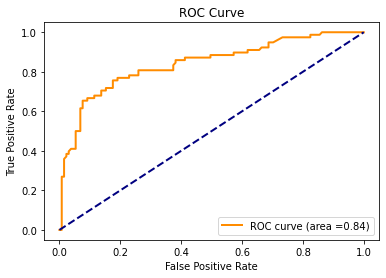

In [76]:
fprs, tprs, thresholds = roc_curve(y_true=y_test, y_score=predictive_probs_test)
auc = roc_auc_score(y_true=y_test, y_score=predictive_probs_test)
plot_roc(fprs, tprs, auc)

In [77]:
auc = roc_auc_score(y_true = y_test,y_score = X1_test['predictive_prob'])
auc

0.8403307888040712

This ROC curve has a AUC value of 0.8403307888040712. By using the current model we will not be able to find a predictive probability threshold that gives us close to perfect TPR and FPR values. In general the model is not perfect, and the AUC test value of 0.8403307888040712 makes it good enough in classifying the test dataset.

In [78]:
from sklearn.metrics import confusion_matrix
def fpr_tpr_thresh(y,pred_prob,thresh):
    yhat = 1*(pred_prob>= thresh)
    tn,fp,fn,tp = confusion_matrix(y_true=y,y_pred = yhat).ravel()
    tpr = tp/(fn+tp)
    fpr = fp/(fp+tn)
    return pd.DataFrame({'threshold':[thresh],'fpr':[fpr],'tpr':[tpr]})

In [79]:
for thresh in np.arange(0,1.01,.001):
    print(fpr_tpr_thresh(y_test,X1_test['predictive_prob'],thresh))

   threshold  fpr  tpr
0        0.0  1.0  1.0
   threshold  fpr  tpr
0      0.001  1.0  1.0
   threshold  fpr  tpr
0      0.002  1.0  1.0
   threshold  fpr  tpr
0      0.003  1.0  1.0
   threshold  fpr  tpr
0      0.004  1.0  1.0
   threshold  fpr  tpr
0      0.005  1.0  1.0
   threshold  fpr  tpr
0      0.006  1.0  1.0
   threshold  fpr  tpr
0      0.007  1.0  1.0
   threshold  fpr  tpr
0      0.008  1.0  1.0
   threshold  fpr  tpr
0      0.009  1.0  1.0
   threshold  fpr  tpr
0       0.01  1.0  1.0
   threshold  fpr  tpr
0      0.011  1.0  1.0
   threshold  fpr  tpr
0      0.012  1.0  1.0
   threshold  fpr  tpr
0      0.013  1.0  1.0
   threshold  fpr  tpr
0      0.014  1.0  1.0
   threshold  fpr  tpr
0      0.015  1.0  1.0
   threshold  fpr  tpr
0      0.016  1.0  1.0
   threshold  fpr  tpr
0      0.017  1.0  1.0
   threshold  fpr  tpr
0      0.018  1.0  1.0
   threshold  fpr  tpr
0      0.019  1.0  1.0
   threshold  fpr  tpr
0       0.02  1.0  1.0
   threshold  fpr  tpr
0      0.02

   threshold       fpr       tpr
0      0.198  0.541985  0.884615
   threshold       fpr       tpr
0      0.199  0.541985  0.884615
   threshold       fpr       tpr
0        0.2  0.541985  0.884615
   threshold       fpr       tpr
0      0.201  0.526718  0.884615
   threshold       fpr       tpr
0      0.202  0.526718  0.884615
   threshold       fpr       tpr
0      0.203  0.519084  0.884615
   threshold      fpr       tpr
0      0.204  0.51145  0.884615
   threshold       fpr       tpr
0      0.205  0.503817  0.884615
   threshold       fpr       tpr
0      0.206  0.503817  0.884615
   threshold       fpr       tpr
0      0.207  0.496183  0.884615
   threshold       fpr       tpr
0      0.208  0.496183  0.871795
   threshold       fpr       tpr
0      0.209  0.496183  0.871795
   threshold       fpr       tpr
0       0.21  0.496183  0.871795
   threshold       fpr       tpr
0      0.211  0.480916  0.871795
   threshold       fpr       tpr
0      0.212  0.480916  0.871795
   threshold

0      0.368  0.091603  0.653846
   threshold       fpr       tpr
0      0.369  0.091603  0.653846
   threshold       fpr       tpr
0       0.37  0.083969  0.653846
   threshold       fpr       tpr
0      0.371  0.083969  0.653846
   threshold       fpr       tpr
0      0.372  0.083969  0.653846
   threshold       fpr       tpr
0      0.373  0.083969  0.653846
   threshold       fpr       tpr
0      0.374  0.076336  0.653846
   threshold       fpr       tpr
0      0.375  0.076336  0.641026
   threshold       fpr       tpr
0      0.376  0.076336  0.641026
   threshold       fpr       tpr
0      0.377  0.076336  0.641026
   threshold       fpr       tpr
0      0.378  0.076336  0.641026
   threshold       fpr       tpr
0      0.379  0.076336  0.628205
   threshold       fpr       tpr
0       0.38  0.076336  0.628205
   threshold       fpr       tpr
0      0.381  0.076336  0.628205
   threshold       fpr       tpr
0      0.382  0.076336  0.628205
   threshold       fpr       tpr
0      0.3

0      0.527  0.068702  0.576923
   threshold       fpr       tpr
0      0.528  0.068702  0.564103
   threshold       fpr       tpr
0      0.529  0.068702  0.564103
   threshold       fpr       tpr
0       0.53  0.068702  0.564103
   threshold       fpr       tpr
0      0.531  0.068702  0.564103
   threshold       fpr       tpr
0      0.532  0.068702  0.564103
   threshold       fpr       tpr
0      0.533  0.068702  0.564103
   threshold       fpr       tpr
0      0.534  0.068702  0.564103
   threshold       fpr       tpr
0      0.535  0.068702  0.564103
   threshold       fpr       tpr
0      0.536  0.068702  0.564103
   threshold       fpr       tpr
0      0.537  0.068702  0.564103
   threshold       fpr       tpr
0      0.538  0.068702  0.564103
   threshold       fpr       tpr
0      0.539  0.068702  0.564103
   threshold       fpr       tpr
0       0.54  0.068702  0.564103
   threshold       fpr       tpr
0      0.541  0.068702  0.564103
   threshold       fpr       tpr
0      0.5

   threshold       fpr       tpr
0      0.689  0.053435  0.448718
   threshold       fpr       tpr
0       0.69  0.053435  0.448718
   threshold       fpr       tpr
0      0.691  0.053435  0.448718
   threshold       fpr       tpr
0      0.692  0.053435  0.448718
   threshold       fpr       tpr
0      0.693  0.053435  0.448718
   threshold       fpr       tpr
0      0.694  0.053435  0.435897
   threshold       fpr       tpr
0      0.695  0.053435  0.435897
   threshold       fpr       tpr
0      0.696  0.053435  0.423077
   threshold       fpr       tpr
0      0.697  0.053435  0.410256
   threshold       fpr       tpr
0      0.698  0.053435  0.410256
   threshold       fpr       tpr
0      0.699  0.045802  0.410256
   threshold       fpr       tpr
0        0.7  0.045802  0.410256
   threshold       fpr       tpr
0      0.701  0.038168  0.410256
   threshold       fpr       tpr
0      0.702  0.030534  0.397436
   threshold       fpr       tpr
0      0.703  0.030534  0.397436
   thresho

0      0.864  0.015267  0.282051
   threshold       fpr       tpr
0      0.865  0.015267  0.282051
   threshold       fpr       tpr
0      0.866  0.015267  0.269231
   threshold       fpr       tpr
0      0.867  0.015267  0.269231
   threshold       fpr       tpr
0      0.868  0.015267  0.269231
   threshold       fpr       tpr
0      0.869  0.015267  0.269231
   threshold       fpr       tpr
0       0.87  0.015267  0.269231
   threshold       fpr       tpr
0      0.871  0.015267  0.269231
   threshold       fpr       tpr
0      0.872  0.015267  0.269231
   threshold       fpr       tpr
0      0.873  0.015267  0.269231
   threshold       fpr       tpr
0      0.874  0.015267  0.269231
   threshold       fpr       tpr
0      0.875  0.015267  0.269231
   threshold       fpr       tpr
0      0.876  0.015267  0.269231
   threshold       fpr       tpr
0      0.877  0.015267  0.269231
   threshold       fpr       tpr
0      0.878  0.015267  0.269231
   threshold       fpr       tpr
0      0.8

0      0.994  0.007634  0.076923
   threshold       fpr       tpr
0      0.995  0.007634  0.076923
   threshold       fpr       tpr
0      0.996  0.007634  0.064103
   threshold       fpr       tpr
0      0.997  0.007634  0.064103
   threshold       fpr       tpr
0      0.998  0.007634  0.038462
   threshold  fpr  tpr
0      0.999  0.0  0.0
   threshold  fpr  tpr
0        1.0  0.0  0.0
   threshold  fpr  tpr
0      1.001  0.0  0.0
   threshold  fpr  tpr
0      1.002  0.0  0.0
   threshold  fpr  tpr
0      1.003  0.0  0.0
   threshold  fpr  tpr
0      1.004  0.0  0.0
   threshold  fpr  tpr
0      1.005  0.0  0.0
   threshold  fpr  tpr
0      1.006  0.0  0.0
   threshold  fpr  tpr
0      1.007  0.0  0.0
   threshold  fpr  tpr
0      1.008  0.0  0.0
   threshold  fpr  tpr
0      1.009  0.0  0.0


For our research purpose we want to have a model that predicts a significant number of true positives (actual high weekend drinking) with a false positive rate that doesn't exceed 15%. With this in mind we can select our threshold. 
With a threshold of 0.308 the false positive rate is 0.145038 (less than 0.15, so good for our analysis) and a true positive rate of 0.705128. So with this model and this threshold the number of observation that are actually positive (high weekend drinking) that are correctly predicted to be positive is 70.5%. The number of observation that are negative (low weekwnd drinking level) but were uncorrectly classified as positive are 14.5%.

## 8. Additional Analysis/Insight

Fitting a multiple linear regression model for additional analysis

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Fit a multiple linear regression model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X1_train, y_train)

y_pred_train = linear_reg_model.predict(X1_train)

r2_train = r2_score(y_train, y_pred_train)

# Print results
print("R-squared (R2) on training set:", r2_train)

# Display coefficients and intercept
coefficients = pd.DataFrame(linear_reg_model.coef_, index=X1_train.columns, columns=['Coefficient'])
intercept = linear_reg_model.intercept_
print("Intercept:", intercept)
print("Coefficients:")
print(coefficients)

R-squared (R2) on training set: 0.2714357524003632
Intercept: 0.3470833278111046
Coefficients:
           Coefficient
age           0.002565
absences      0.036967
famrel       -0.008288
studytime    -0.030856
sex_M         0.117296
Dalc          0.217685


The additional analysis of fitting a multiple linear regression model contributes to the secondary research goals of developing reliable interpretability into variable relationships. The coefficients of the multiple linear regression model provide insights into the direction and strength of the relationships between each explanatory variable and the response variable (weekend alcohol consumption). For example, the positive coefficient for 'Dalc' suggests that an increase in weekday alcohol consumption is associated with an increase in weekend alcohol consumption. Similarly, the negative coefficient for 'famrel' indicates that a higher rating of family relationships is associated with lower levels of weekend alcohol consumption. In addition, the coefficients allow you to identify which factors have a more substantial impact on the predicted weekend alcohol consumption. For instance, the relatively higher coefficient for 'Dalc' implies that weekday alcohol consumption is a more influential factor in predicting weekend alcohol consumption compared to other variables.

## 9. Conclusion

The AUC value of 0.8403 suggests that the model performs well in distinguishing between students with low and high weekend alcohol consumption levels.
The model is suitable for identifying high-risk students, which aligns with the motivation of school counselors and administrators to target intervention programs effectively. The AUC value of 0.8403 indicates a relatively high ability to discriminate between positive and negative, making it a valuable tool for identifying students at risk of problematic drinking. While the model performs well, it's essential to acknowledge that no model is perfect. The ROC curve suggests that there is a trade-off between true positive rate and specificity true negative rate. So, the model may not provide a perfect threshold for both TPR and FPR. In addition, while it is highly likely, it cannot be stated with certainty that the chosen logistic regression model is guaranteed to yield the highest possible average test AUC out of all possible models with this dataset. There are several techniques and steps that a more "complete" analysis might explore in search of a model with the highest average test AUC. For example, instead of just using backwards elimination with cross validation, performing techniques mentioned in option B or C or Kmeans might also made our interpretaion more accurate. As for shortcomings in our analysis, the dataset was collected in 2008 from two Portuguese schools, and its generalizability to other regions or time periods is uncertain. More recent data or data from different demographics could strengthen the model's reliability. Also, integrating external data sources, such as socioeconomic factors, could provide additional context and potentially improve model performance. External data sources, such as census data, economic indicators, or community profiles, can provide a broader context to understand the environment in which students live. For example, variables like median household income, unemployment rates, or crime rates in the students' neighborhoods can offer insights into the socioeconomic conditions that may influence drinking behaviors.

## References

<sup>1</sup>National Research Council (US) and Institute of Medicine (US) Committee on Developing a Strategy to Reduce and Prevent Underage Drinking; Bonnie RJ, O'Connell ME, editors. Reducing Underage Drinking: A Collective Responsibility. Washington (DC): National Academies Press (US); 2004. 10, Youth-Oriented Interventions. Available from: https://www.ncbi.nlm.nih.gov/books/NBK37617/

<sup>2</sup>Centers for Disease Control and Prevention. (2021, October 6). Underage Drinking. https://www.cdc.gov/alcohol/fact-sheets/underage-drinking.htm

‌

‌